In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

from sim_simulation import p
sys.path.append('models')
from models import Feedforward
# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform1d import DWT1d
from utils import get_1dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_1dreconstruct

In [2]:
# seed
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# wavelet transform 
wt = DWT1d(wave='db5', mode='zero', J=4, init_factor=1, noise_factor=0)
# freeze layers
for param in wt.parameters():
    param.requires_grad = False  

n = 55000
d = 64
X = torch.randn(n, d)
X_t = wt(X.unsqueeze(1))
# re = wt(torch.randn(1, 1, p.d).to(device))
# data_t = ()
# for scale in range(len(re)):
#     dim = re[scale].size(2)
#     pr = torch.bernoulli(0.1 * torch.ones(p.n, 1, dim))
#     rn = abs(torch.randn(p.n, 1, dim))
#     data_t += ((pr * rn).to(device),)
# data = wt.inverse(data_t)

# generate y
beta = ()
for i in range(len(X_t)):
    beta += (torch.zeros_like(X_t[i][0:1,...]),)
beta[p.scale_knockout][..., p.idx_knockout - p.window: p.idx_knockout + p.window + 1] = 2.0

y = 0
for x, b in zip(X_t, beta):
    y += torch.matmul(x.squeeze(), b.squeeze())
eps = 0.1 * torch.randn_like(y)
y = y + eps
y = y[:,None]

create data

In [3]:
X_train = X[:50000]
y_train = y[:50000]
X_test = X[50000:]
y_test = y[50000:]

model = Feedforward(input_size=d).to(device)
train_loader = DataLoader(TensorDataset(X_train, y_train), 
                          batch_size=100,
                          shuffle=True) 
test_loader = DataLoader(TensorDataset(X_test, y_test), 
                          batch_size=100,
                          shuffle=False) 

train model

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
num_epochs = 20

train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        # zero grad
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(y, output)
        
        # backward
        loss.backward()
        # update step
        optimizer.step()          
        
        iter_loss = loss.item()   
        epoch_loss += iter_loss

        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), iter_loss), end='')              

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses.append(mean_epoch_loss)

# save model
torch.save(model.state_dict(), 'models/FFN.pth') 
    

Train Epoch: 19 [49900/50000 (100%)]	Loss: 0.016015

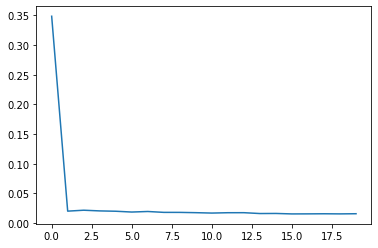

In [5]:
plt.plot(train_losses)

model prediction

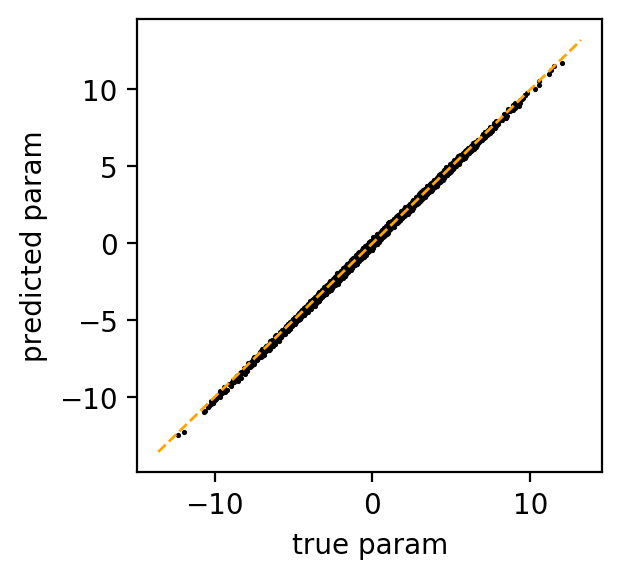

In [6]:
# check prediction
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for data, y in test_loader:
        result['y'].append(y.squeeze().detach().cpu())
        result['pred'].append(model(data.to(device)).squeeze().detach().cpu())
        
fig = plt.figure(dpi=200, figsize=(3, 3))
ax = fig.add_subplot(1,1,1)
ax.scatter(torch.cat(result['y']),
           torch.cat(result['pred']),
           marker=".", 
           alpha=1, 
           zorder=0, 
           color="black",
           s=3)
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, zorder=2, color="orange", linestyle='--', linewidth=1)
ax.set_xlabel("true param")
ax.set_ylabel("predicted param")
plt.show()